In [1]:
!pip install datasets

In [2]:
# -----------------------
# Dataset Download and Split (Hugging Face -> train/test folders)
# -----------------------

import os
from datasets import load_dataset

def save_split(split_name, split_data, base_dir):
    split_dir = os.path.join(base_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)
    
    for i, row in enumerate(split_data):
        label = row["label"]
        class_dir = os.path.join(split_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)
        
        image = row["image"]
        image_path = os.path.join(class_dir, f"{split_name}_{i}.jpg")
        image.save(image_path)

dataset_path = "data/azerbaijan-landmarks-dataset"
if not os.path.exists(os.path.join(dataset_path, "train")):
    print("Downloading and preparing dataset...")
    dataset = load_dataset("khaleed-mammad/azerbaijan-landmarks-dataset")
    os.makedirs(dataset_path, exist_ok=True)
    save_split("train", dataset["train"], dataset_path)
    save_split("test", dataset["test"], dataset_path)
    print("Dataset split into 'train' and 'test' folders.")
else:
    print("Dataset already exists.")

Dataset already exists.


Using device: cpu
Loading dataset without augmentation...
Creating baseline model...


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training baseline model...
Epoch 1/10 — train_acc: 0.2577, test_acc: 0.4474
Epoch 2/10 — train_acc: 0.5205, test_acc: 0.6842
Epoch 3/10 — train_acc: 0.6809, test_acc: 0.8421
Epoch 4/10 — train_acc: 0.8294, test_acc: 0.9211
Epoch 5/10 — train_acc: 0.8840, test_acc: 0.9605
Epoch 6/10 — train_acc: 0.9078, test_acc: 0.9605
Epoch 7/10 — train_acc: 0.9078, test_acc: 0.9737
Epoch 8/10 — train_acc: 0.9437, test_acc: 0.9803
Epoch 9/10 — train_acc: 0.9471, test_acc: 0.9737
Epoch 10/10 — train_acc: 0.9437, test_acc: 0.9868

 Training model with data augmentation...
Epoch 1/10 — train_acc: 0.3055, test_acc: 0.5197
Epoch 2/10 — train_acc: 0.5171, test_acc: 0.6908
Epoch 3/10 — train_acc: 0.6365, test_acc: 0.7697
Epoch 4/10 — train_acc: 0.6945, test_acc: 0.8684
Epoch 5/10 — train_acc: 0.7509, test_acc: 0.8684
Epoch 6/10 — train_acc: 0.8123, test_acc: 0.9013
Epoch 7/10 — train_acc: 0.8020, test_acc: 0.9211
Epoch 8/10 — train_acc: 0.8584, test_acc: 0.9079
Epoch 9/10 — train_acc: 0.8413, test_acc: 0.907

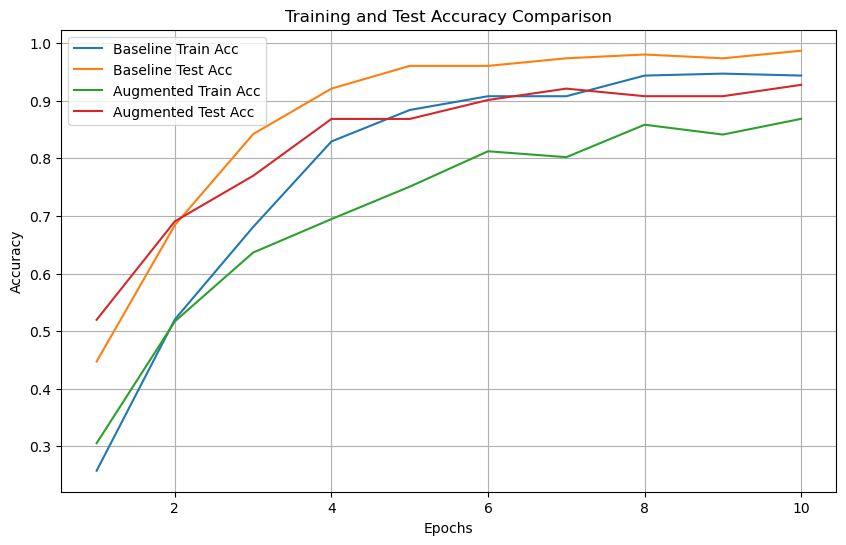

Training completed!
 Models saved in 'models/'
 Graph saved as 'images/loss_graph.png'


In [3]:
# -----------------------
# CNN Model Training for Landmark Recognition in Azerbaijan
# Team 5 – 5 classes: Maiden Tower, Deniz Mall, Shirvanshahlar, Dede Gorgud, Heydar Aliyev Center
# -----------------------

import os
import json
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import importlib.util

# -----------------------
# 0. Dynamic Import Helper
# -----------------------
def import_from_file(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

# Import custom modules from code/
code_path = "code"
data_loader = import_from_file("data_loader", os.path.join(code_path, "data_loader.py"))
model_file = import_from_file("model", os.path.join(code_path, "model.py"))
utils = import_from_file("utils", os.path.join(code_path, "utils.py"))

# -----------------------
# 1. Set Device
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------
# 2. Parameters
# -----------------------
data_dir = "data/azerbaijan-landmarks-dataset"
image_size = 224
batch_size = 32
num_classes = 5
epochs = 10

# ----------------------------
# 3. Load Dataset (Baseline)
# ----------------------------
print("Loading dataset without augmentation...")
train_loader, test_loader, class_names = data_loader.get_data_loaders(
    data_dir=data_dir,
    image_size=image_size,
    batch_size=batch_size,
    augmented=False  # No augmentation for baseline
)

# ----------------------------
# 4. Load Model (ResNet-18)
# ----------------------------
print("Creating baseline model...")
model = model_file.get_model(num_classes=num_classes, dropout=0.3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

# ----------------------------
# 5. Train Baseline Model
# ----------------------------
print("Training baseline model...")
baseline_train_acc, baseline_test_acc = utils.train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs,
    save_path="models/0_model_team_5.pth"
)

# ----------------------------
# 6. Train with Augmentation
# ----------------------------
print("\n Training model with data augmentation...")

# Reload model for fair comparison
model_aug = model_file.get_model(num_classes=num_classes, dropout=0.3)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.0005, weight_decay=1e-5)

# Load dataset with augmentation
train_loader_aug, test_loader_aug, _ = data_loader.get_data_loaders(
    data_dir=data_dir,
    image_size=image_size,
    batch_size=batch_size,
    augmented=True
)

aug_train_acc, aug_test_acc = utils.train_model(
    model=model_aug,
    train_loader=train_loader_aug,
    test_loader=test_loader_aug,
    optimizer=optimizer_aug,
    criterion=criterion,
    device=device,
    epochs=epochs,
    save_path="models/1_model_team_5.pth"
)

# ----------------------------
# 7. Plot Accuracy Curves
# ----------------------------
print("Plotting accuracy curves...")
epochs_range = list(range(1, epochs + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, baseline_train_acc, label="Baseline Train Acc")
plt.plot(epochs_range, baseline_test_acc, label="Baseline Test Acc")
plt.plot(epochs_range, aug_train_acc, label="Augmented Train Acc")
plt.plot(epochs_range, aug_test_acc, label="Augmented Test Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig("images/loss_graph.png")
plt.show()

# ----------------------------
# 8. Save Class Names
# ----------------------------
with open("models/classes.json", "w") as f:
    json.dump(class_names, f)

print("Training completed!\n Models saved in 'models/'\n Graph saved as 'images/loss_graph.png'")